In [32]:
import numpy as np
import pandas as pd
import os
import datetime
import nbconvert as nbc
#import scipy.fftpack


#define the path of the export path
BASEPATH = "../webCrawler/LSTMlib/Data/dataset/"
FILENAME = "GoogleSheetstockdata.pymd"

def loaddataFromGoogleSheet():
    dir_file =  os.listdir(os.getcwd())
    stockdata = []
    for i in dir_file:
        if i.find('.csv') >=0: 
            stockdata.append(pd.read_csv(i))
    stockdata = pd.concat(stockdata)
    return stockdata

def formatRawData(data): 
    print("Formating the data....")
    data = formatDateToDatTimeObj(data)
    print("End of formating the data.")
    return data
    
def formatDateToDatTimeObj(data): 
    print("Converting String Date to python DateTime object...")
    data["DateTime"]= data["Date"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y %H:%M:%S"))  
    return data

def getStockCodeFromGoogleSheet(pd_data): 
    print("Get the index...")
    return pd_data.Stock_Code.unique()

def exportStockDataFromGoogleSheet(model, filename=None):
    try:
        import cPickle as pik
    except:
        import pickle as pik
        
    if filename == None:
        filename = BASEPATH + FILENAME
    else: 
        filename = BASEPATH + filename
    print("Exporting the data.......")
    try:
        with open(filename, "wb") as f:
            pik.dump(model, f)
        print("Exported the data to %s successfully!" % filename)
        return filename, True
    except: 
        print("Cannot export the data to the destination folder")
        return "Error" , False
        
def runExportData(): 
    stockdata_model = {}
    print("Loading the data")
    stockdata_model["data"] = loaddataFromGoogleSheet()
    stockdata_model["data"] = formatRawData(stockdata_model["data"])
    stockdata_model["index"] = getStockCodeFromGoogleSheet(stockdata_model["data"])
    exportStockDataFromGoogleSheet(stockdata_model)  
    

def main(): 
    runExportData()
    
if __name__ == '__main__':
    main()

Loading the data
Formating the data....
Converting String Date to python DateTime object...
End of formating the data.
Get the index...
Exporting the data.......
Exported the data to ../webCrawler/LSTMlib/Data/dataset/GoogleSheetstockdata.pymd successfully!


In [30]:
runExportData()

Loading the data
Formating the data....
Converting String Date to python DateTime object...
End of formating the data.
Get the index...
Exporting the data.......
Exported the data to ../webCrawler/LSTMlib/Data/dataset/GoogleSheetstockdata.pymd successfully!


C:\Users\Allen\Anaconda3\envs\tensorflow_gpu2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


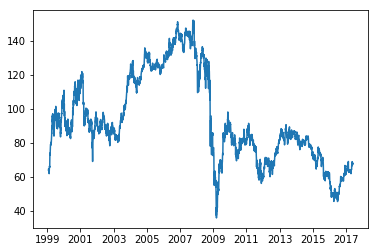

In [5]:
import matplotlib
import matplotlib.pyplot as plt


stockdata = loaddataFromGoogleSheet()
stockdata.head()

hsbc = stockdata[stockdata['Stock_Code'] == "0005.HK" ] 

hsbc["DateTime"] = hsbc["Date"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y %H:%M:%S"))  

hsbc.head()

plt.plot( hsbc.DateTime, hsbc.Open)

plt.show()

n = hsbc["Open"].shape[0]
ffthsbc = np.fft.fft(hsbc["Open"], n )

def extractData( startpoint, endpoint, data):
    return data.iloc[startpoint: endpoint]


def shiftData( startpoint, data): 
    return data.iloc[startpoint+1:]


def convertinput(windowsize = 10): 
    return 1, windowsize

def checkend(windowsize, data): 
    if data.shape[0] < windowsize:
        return True
    else:
        return False
    


def convertToPolar(npData): 
    return np.absolute(npData), np.angle(npData, deg=True)

def sortedPolar( data): 
    zipped = sorted(zip(data[0], data[1]) , reverse=True) 
    abslist = []
    anglelist = []
    for abscomp , anglecomp in zipped: 
        abslist.append(abscomp)
        anglelist.append(anglecomp)
    return abslist, anglelist

def convertTimeSeriesToFFT(data): 
    n = data.shape[0]
    fttdata = np.fft.fft( data, n )
    return sortedPolar( convertToPolar(fttdata))

def FFTExtractedData( data, windowsize = 10): 
    startpoint , endpoint = convertinput(windowsize)
    extractdata = extractData( startpoint, endpoint, data)
    return convertTimeSeriesToFFT(extractdata) , shiftData(startpoint, data)

def rollingFFT(data, windowsize = 10): 
    returnlist = [] 
    while( not checkend(windowsize, data) ):
        fftdata, data = FFTExtractedData(data , windowsize)
        returnlist.append([fftdata[0][:3], fftdata[1][:3]])
    return  returnlist
    '''
    if not checkend(windowsize, data): 
        fftdata, shiftdata = FFTExtractedData(data , windowsize)
        print(shiftdata.iloc[0])
        return rollingFFT(shiftdata, windowsize).append([fftdata[0][0], fftdata[1][0]])
    else:
        return []
    '''

def rollingFFTFullData(data, windowsize = 10): 
    returnlist = [] 
    while( not checkend(windowsize, data) ):
        fftdata, data = FFTExtractedData(data , windowsize)
        returnlist.append([fftdata[0], fftdata[1]])
    return  returnlist



#fullFFTData = rollingFFT(hsbc.Close[:2000], 100)
fullFFTData = rollingFFTFullData(hsbc.Close[:2000], 200)



In [2]:
a = pd.DataFrame(fullFFTData)
len(a[1][0])

199

In [5]:
def filterdata(data, filterlist ):
    t = []
    for i in range(len(filterlist)):
        if filterlist[i]: 
            t.append(data[i])
    return t

fftplotdata = []
#indexlist = [0, 30, 60 , 100, 120, 160, 190]
#indexlist = [0, 50 , 100, 150, 190]
indexlist = [0, 100, 190]



for index in indexlist:
    datafilter = [x >= 0 for x in a[1][index]]
    ang = filterdata(a[1][index], datafilter)
    absolute = filterdata(a[0][index], datafilter)
    zipped = list(sorted(zip(ang, absolute)))
    ang = [x[0] for x in zipped]
    absolute = [x[1] for x in zipped]
    fftplotdata.append( { "index":index , "ang": ang, "abs_value":absolute} )



'\nindex1= 100\ndatafilter1 = [ x>= 0  for x in a[1][index1]] \nang1 = filterdata(a[1][index1], datafilter1)\nabsolute1 = filterdata(a[0][index1], datafilter1)\nzipped1 = sorted(zip(ang1, absolute1))\nzipped1 = list(zipped1)\nang1 = [x[0] for x in zipped1]\nabsolute1 = [x[1] for x in zipped1] \n\nindex2 = 160\ndatafilter2 = [ x>= 0  for x in a[1][index2]] \nang2 = filterdata(a[1][index2], datafilter2)\nabsolute2 = filterdata(a[0][index2], datafilter2)\nzipped2 = sorted(zip(ang2, absolute2))\nzipped2 = list(zipped2)\nang2= [x[0] for x in zipped2]\nabsolute2 = [x[1] for x in zipped2]\n'

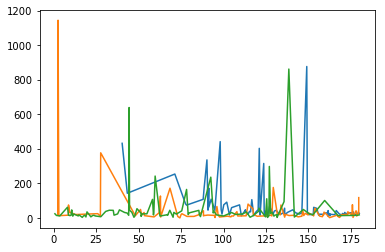

In [7]:
for data in fftplotdata: 
    plt.plot(data["ang"][1:], data["abs_value"][1:],label='index:%d' % data["index"]  )
plt.show()

In [30]:
def sortfilterdata(inputdata, extracted_window = 0): 
    retinputdata = {}
    if extracted_window <=0:
        extracted_window = len(inputdata["abs_value"])-1
    #print(extracted_window)
    zipped = list(sorted( zip( [ inputdata["abs_value"] , inputdata["ang"]  ] ), reverse = True))    
    #print(zipped[0][0])
    retinputdata["abs_value"] = [x[0] for x in zipped[0]][:extracted_window]
    retinputdata["ang"] = [x[1] for x in zipped[1]][:extracted_window]
    zipped = list(sorted( zip( [ retinputdata["ang"] , retinputdata["abs_value"]  ] )))    
    retinputdata["ang"] = [x[0] for x in zipped]
    retinputdata["abs_value"] = [x[0] for x in zipped]
    retinputdata["index"] = inputdata["index"]
    return retinputdata
    
def sortAlldata(inputdataCollection, extracted_window = 0):
    newsortedextracteddata = []
    for data in inputdataCollection: 
        a = sortfilterdata(data, extracted_window)
        newsortedextracteddata.append(a)
    return newsortedextracteddata

newsortedextracteddata = sortAlldata(fftplotdata, 5)

        

In [31]:
newsortedextracteddata

[{'abs_value': [[40.374001631026729], [17644.600000000002]],
  'ang': [[40.374001631026729], [17644.600000000002]],
  'index': 0},
 {'abs_value': [[2.4818505653248786], [18968.5]],
  'ang': [[2.4818505653248786], [18968.5]],
  'index': 100},
 {'abs_value': [[0.81989517093632691], [21374.5]],
  'ang': [[0.81989517093632691], [21374.5]],
  'index': 190}]